In [11]:
import jqdata               #导入聚宽函数库
from six import StringIO    #使用聚宽readfile函数
import numpy as np
import pandas as pd
import talib
from __future__ import division

import time

import datetime


import matplotlib.pyplot as plt


stock_to_choose = get_fundamentals(query(
        valuation.code, valuation.pe_ratio, 
        valuation.pb_ratio,valuation.market_cap, 
        indicator.eps, indicator.inc_net_profit_annual
    ).filter(
#         indicator.inc_net_profit_annual > 50
#         valuation.pe_ratio < 100,
        valuation.pe_ratio > 2
    ).order_by(
        valuation.market_cap.asc()
    ), date=None)

stock_list_all = list(stock_to_choose['code'])

# stock_list_all = get_index_stocks('000300.XSHG')

# print stock_list_all

选取股票

In [12]:
stock_list_all = stock_list_all[:]
# stock_list_all = ['002558.XSHE', '600362.XSHG', '600516.XSHG', '603260.XSHG', '000898.XSHE', '002202.XSHE', '600271.XSHG', '600066.XSHG', '600377.XSHG', '002602.XSHE']
# stock_list_all = ['399300.XSHE']
# print stock_list_all

In [13]:
stat = {}                      #计算失败的统计次数{时间：次数}

attempt_count = {}             #计算总的尝试次数{时间：次数}
 
for stock_name in stock_list_all:
    stock_price = get_price(stock_name, count = 1000, end_date='2018-5-31', frequency='daily', 
                            fields=['open', 'close'], fq='none')

    stock_price[stock_price['close']==0]=np.nan
    close_price= stock_price.dropna()

    close_price = stock_price['close']
    
    if len(close_price) > 50:
        dif, dea, macd = talib.MACD(stock_price['close'].values, fastperiod=13, slowperiod=26, signalperiod=9)
        
        id_x_gold = np.where((macd[:-1] < 0) & (macd[1:] > 0))[0] + 1

        id_x_gold = [elem for elem in id_x_gold if elem < len(close_price) - 10 ]  # 防止越界
               
        
        for gold_date in id_x_gold:                  #逐个判断金叉的时刻

            if dif[gold_date] > 0 :                             #dif>0，表明处于多头市场

                if attempt_count.has_key(close_price.index[gold_date]):
                    attempt_count[close_price.index[gold_date]] += 1
                else:
                    attempt_count[close_price.index[gold_date]] = 1
            
            
            if dif[gold_date] > 0 :                             #dif>0，表明处于多头市场
                if stat.has_key(close_price.index[gold_date]):          #判断这个日期是否录入，此次金录入失败的日期，看失败次数的平均分布
                    days = 0
                    
                    for price_cmp in close_price[gold_date:gold_date + 11]:
                        if price_cmp < 0.997*close_price[gold_date]:
                            stat[close_price.index[gold_date]] += 1
                            break
                        if price_cmp > 1.005*close_price[gold_date]:
                            stat[close_price.index[gold_date]] += 0
                            break

                        if days > 9 :
                            stat[close_price.index[gold_date]] += 0
                            break
                        days += 1

                    
                    
                else:
                    stat[close_price.index[gold_date]] = 0
                    days = 0
                    
                    for price_cmp in close_price[gold_date:gold_date + 11]:
                        if price_cmp < 0.997*close_price[gold_date]:
                            stat[close_price.index[gold_date]] += 1
                            break
                        if price_cmp > 1.005*close_price[gold_date]:
                            stat[close_price.index[gold_date]] += 0
                            break

                        if days > 9 :
                            stat[close_price.index[gold_date]] += 0
                            break
                        days += 1

# print stat,attempt_count

之前的统计方法不正确，应该按月度统计成功率/失败率，累加所有金叉的次数

优化算法：调整成功的标准
1、只要在十天内得到最高值，就算成功
2、十天内跌两个点，0.98，则为失败

In [14]:
# print set(attempt_count.keys())
month_key = ''
stat_lose_rate = {}

for month_th in sorted(set(attempt_count.keys())):
    
    month_key = str(time.strftime("%Y-%m",time.strptime(str(month_th),"%Y-%m-%d %H:%M:%S")))
    

    if stat_lose_rate.has_key(month_key):
        if stat.has_key(month_th):
            stat_lose_rate[month_key][0] += stat[month_th]
        
        stat_lose_rate[month_key][1] += attempt_count[month_th]
    else:
        stat_lose_rate[month_key] = [0,0]
        
        if stat.has_key(month_th):
            stat_lose_rate[month_key][0] += stat[month_th]
            
        stat_lose_rate[month_key][1] += attempt_count[month_th]
        
        
print stat_lose_rate

{'2018-02': [125, 212], '2014-09': [879, 2183], '2014-08': [541, 1025], '2018-05': [275, 499], '2014-07': [547, 1072], '2014-06': [152, 414], '2018-04': [479, 738], '2015-11': [558, 1211], '2015-10': [34, 89], '2015-12': [813, 1555], '2017-12': [158, 264], '2017-11': [287, 534], '2017-10': [683, 1079], '2016-10': [332, 606], '2016-11': [648, 1227], '2016-12': [290, 487], '2015-06': [297, 656], '2015-07': [36, 85], '2015-04': [766, 1607], '2015-05': [588, 1895], '2015-02': [294, 809], '2015-03': [364, 1016], '2015-01': [391, 685], '2014-12': [493, 938], '2014-10': [618, 1095], '2014-11': [763, 1443], '2015-08': [43, 90], '2015-09': [13, 32], '2017-08': [373, 708], '2017-09': [672, 1072], '2018-01': [260, 439], '2017-01': [163, 306], '2017-02': [193, 349], '2017-03': [535, 896], '2017-04': [310, 545], '2017-05': [145, 245], '2017-06': [149, 269], '2017-07': [330, 580], '2016-07': [424, 634], '2016-06': [253, 480], '2016-05': [471, 704], '2016-04': [331, 626], '2016-03': [114, 250], '2016

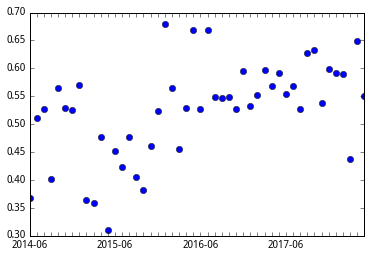

失败次数：17489
正确次数：16612
胜率为: 0.487141


In [15]:

x = [d for d in sorted(stat_lose_rate)]
# print datetime.datetime.strptime(x[0], "%Y-%m").month

zz = [x[i] if datetime.datetime.strptime(x[i], "%Y-%m").month==6 else "" for i in range(len(x))]

# print zz

y = [stat_lose_rate[d][0]/stat_lose_rate[d][1]  for d in x]

x1 = [i for i in range(len(x))]
# print x,y


# print len(x),len(y)

# pltxticks(x)
# print time.strptime(x[0],"%Y-%m").month()
# print [x if time.strptime(d,"%Y-%m").month else y for d in x]

plt.xticks(x1,zz)
plt.plot(x1,y,'o')

plt.show()

# print "正确次数：%d" % len([d>0.5 for d in y])


# print int(sum([stat_lose_rate[d][0] for d in x]))
# print int(sum([stat_lose_rate[d][1] for d in x]))
print "失败次数：%d" % (int(sum([stat_lose_rate[d][0] for d in x])))
print "正确次数：%d" % (int(sum([stat_lose_rate[d][1] for d in x])) - int(sum([stat_lose_rate[d][0] for d in x])))
print "胜率为: %f" % ((int(sum([stat_lose_rate[d][1] for d in x])) - int(sum([stat_lose_rate[d][0] for d in x])))/int(sum([stat_lose_rate[d][1] for d in x])))

失败比例如图，在某些时间段高于50%，某些时间段低于50%，整体看来并没有明确的方向
单纯使用该指标不能达到预期的效果，且后期的错误率逐步上升
部分月份错误率特别高
牛市、熊市还是有比较大的区别

通过逐个分析股票的表现：
1、每月对每个股票进行错误率统计
2、按照错误率进行打分
3、重点观察高评分的股票发生错误的概率

In [16]:
#统计汇总
stock_stat = {}          #{股票：{日期：[总次数, 失败次数]}}

 
for stock_name in set(stock_list_all):
    attempt_count = {}
    stat = {}
    
    stock_price = get_price(stock_name, count = 3000, end_date='2018-5-31', frequency='daily', 
                            fields=['open', 'close'], fq='none')

    stock_price[stock_price['close']==0]=np.nan
    close_price= stock_price.dropna()

    close_price = stock_price['close']
    
    if len(close_price) > 50:

        dif, dea, macd = talib.MACD(stock_price['close'].values, fastperiod=13, slowperiod=26, signalperiod=9)
        
        id_x_gold = np.where((macd[:-1] < 0) & (macd[1:] > 0))[0] + 1

        id_x_gold = [elem for elem in id_x_gold if elem < len(close_price) - 10 ]  # 防止越界
               
        
        for gold_date in id_x_gold:                  #逐个判断金叉的时刻

            if dif[gold_date] > 0 :                             #dif>0，表明处于多头市场

                if attempt_count.has_key(close_price.index[gold_date]):
                    attempt_count[close_price.index[gold_date]] += 1
                else:
                    attempt_count[close_price.index[gold_date]] = 1
            
            
            if dif[gold_date] > 0 :                             #dif>0，表明处于多头市场
                if stat.has_key(close_price.index[gold_date]):          #判断这个日期是否录入，此次金录入失败的日期，看失败次数的平均分布
                    days = 0
                    
                    for price_cmp in close_price[gold_date:gold_date + 11]:
                        if price_cmp < 0.987*close_price[gold_date]:
                            stat[close_price.index[gold_date]] += 1
                            break
                        if price_cmp > 1.015*close_price[gold_date]:
                            stat[close_price.index[gold_date]] += 0
                            break

                        if days > 9 :
                            stat[close_price.index[gold_date]] += 0
                            break
                        days += 1
                else:
                    stat[close_price.index[gold_date]] = 0
                    
                    days = 0
                    
                    for price_cmp in close_price[gold_date:gold_date + 11]:
                        if price_cmp < 0.987*close_price[gold_date]:
                            stat[close_price.index[gold_date]] += 1
                            break
                        if price_cmp > 1.015*close_price[gold_date]:
                            stat[close_price.index[gold_date]] += 0
                            break

                        if days > 9 :
                            stat[close_price.index[gold_date]] += 0
                            break
                        days += 1
    

    stock_stat[stock_name] = {}
    for date in attempt_count.keys():
        stock_stat[stock_name][date] = [attempt_count[date], stat[date] if stat.has_key(date) else 0]
        


In [17]:
#stock_stat   {股票：{日期：[总次数, 失败次数]}}

# print stock_stat

# 按年度进行股票评级 {年度：{股票：评级}}
stock_rate = {}

# print stock_stat
attempt_count = 0
win_count = 0

    
for year in range(2000,2019):
    stock_rate[year] = {}
    
    for stock_name in stock_stat.keys():

        attempt_count = 0
        win_count = 0


        for stat_year in stock_stat[stock_name].keys():
            
            if year == datetime.datetime.strptime(str(stat_year), "%Y-%m-%d %H:%M:%S").year:
                attempt_count += 1
                
                if stock_stat[stock_name][stat_year][1] == 0:
                    win_count +=1

        
        # 开始赋值评级
        if attempt_count != 0:
            if win_count/attempt_count > 0.51:
                stock_rate[year][stock_name] = 1
            elif win_count/attempt_count < 0.5:
                stock_rate[year][stock_name] = -1
            else:
                stock_rate[year][stock_name] = 1
        else:
            stock_rate[year][stock_name] = 1
        
# print stock_rate        


In [18]:
winners = 0
loser = 0
evener = 0

winner_list = {}
loser_list = {}
evener_list = {}

for yearth in sorted(stock_rate.keys()):
    winners = 0
    loser = 0
    evener = 0
    winner_list[yearth] = []
    loser_list[yearth] = []
    evener_list[yearth] = []
    
    for stock_name  in stock_rate[yearth]:
        if stock_rate[yearth][stock_name] == -1:
            loser += 1
            loser_list[yearth].append(stock_name)
            
        elif stock_rate[yearth][stock_name] == 0:
            evener += 1
            evener_list[yearth].append(stock_name)
            
        elif stock_rate[yearth][stock_name] == 1:
            winners += 1
            winner_list[yearth].append(stock_name)
        
#     print "In %d" % yearth
#     print "Winners:%d" % winners
#     print winner_list[yearth]
#     print ""
#     print "Loser:%d" % loser
#     print loser_list[yearth]
#     print ""
#     print "Evener:%d" % evener
#     print evener_list[yearth]
#     print ""

计算每年胜者组中，有多少比例转出，转出的比例如果低于50%，则证明押注胜者组是一个有效的策略


In [19]:
transfer_rate = 0
for yearth in sorted(stock_rate.keys()):
    transfer_rate = 0
    if winner_list.has_key(yearth) & winner_list.has_key(yearth+1):
        if len(winner_list[yearth]) != 0:
            transfer_rate = len(set(winner_list[yearth]).intersection(set(winner_list[yearth+1]))) / len(winner_list[yearth])

            print "在 %d 年，留存概率为: %f" % (yearth,transfer_rate)
            
        
yearth = 2010
print set(winner_list[yearth]).intersection(set(winner_list[yearth+1])).intersection(set(winner_list[yearth+2])).intersection(set(winner_list[yearth+3])).intersection(set(winner_list[yearth+4])).intersection(set(winner_list[yearth+5]))

在 2000 年，留存概率为: 1.000000
在 2001 年，留存概率为: 1.000000
在 2002 年，留存概率为: 1.000000
在 2003 年，留存概率为: 1.000000
在 2004 年，留存概率为: 1.000000
在 2005 年，留存概率为: 0.888235
在 2006 年，留存概率为: 0.931335
在 2007 年，留存概率为: 0.896226
在 2008 年，留存概率为: 0.869198
在 2009 年，留存概率为: 0.831849
在 2010 年，留存概率为: 0.795686
在 2011 年，留存概率为: 0.762356
在 2012 年，留存概率为: 0.730953
在 2013 年，留存概率为: 0.810074
在 2014 年，留存概率为: 0.813705
在 2015 年，留存概率为: 0.682860
在 2016 年，留存概率为: 0.620448
在 2017 年，留存概率为: 0.787147
set(['002897.XSHE', '603309.XSHG', '300611.XSHE', '002906.XSHE', '603585.XSHG', '603041.XSHG', '002245.XSHE', '300419.XSHE', '603389.XSHG', '601229.XSHG', '600903.XSHG', '603703.XSHG', '300643.XSHE', '603901.XSHG', '002792.XSHE', '300567.XSHE', '603336.XSHG', '603603.XSHG', '300395.XSHE', '002858.XSHE', '603776.XSHG', '002227.XSHE', '603306.XSHG', '300675.XSHE', '300341.XSHE', '601019.XSHG', '603033.XSHG', '600704.XSHG', '300620.XSHE', '603331.XSHG', '603933.XSHG', '603709.XSHG', '603089.XSHG', '002467.XSHE', '600561.XSHG', '300631.XSHE', '3006